In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from string import ascii_lowercase
import requests
import random

In [2]:
# get list of words
words = requests.get(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
    ).text.splitlines()
print(f'{len(words)=}')
print(f'{words[:5]=}')

len(words)=32033
words[:5]=['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# integer mappings of characters
chars = ascii_lowercase
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# total characters (possible prediction outcomes)
vocab_size = len(itos)
# number of previous characters to consider for prediction
block_size = 3
# dimensionality of character embedding vectors
n_embed = 10
# number of neurons in the hidden layer
n_hidden = 200

In [5]:
# build dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# use build_dataset for train/val/test splits
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# training, val, and testing dataset sizes
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# model parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn(vocab_size,                        generator=g)
parameters = [C, W1, b1, W2, b2]
print(f'{C.shape=}')
print(f'{W1.shape=}')
print(f'{b1.shape=}')
print(f'{W2.shape=}')
print(f'{b2.shape=}')
print('Parameter total:', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

C.shape=torch.Size([27, 10])
W1.shape=torch.Size([30, 200])
b1.shape=torch.Size([200])
W2.shape=torch.Size([200, 27])
b2.shape=torch.Size([27])
Parameter total: 11897


In [10]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 26.0277
  10000/ 200000: 2.4983
  20000/ 200000: 2.4739
  30000/ 200000: 2.3268
  40000/ 200000: 2.4167
  50000/ 200000: 2.1902
  60000/ 200000: 2.2417
  70000/ 200000: 2.4742
  80000/ 200000: 2.8131
  90000/ 200000: 2.2967
 100000/ 200000: 2.6612
 110000/ 200000: 2.1426
 120000/ 200000: 2.1833
 130000/ 200000: 2.3479
 140000/ 200000: 2.0264
 150000/ 200000: 2.2303
 160000/ 200000: 2.5972
 170000/ 200000: 2.2203
 180000/ 200000: 2.1190
 190000/ 200000: 2.0404


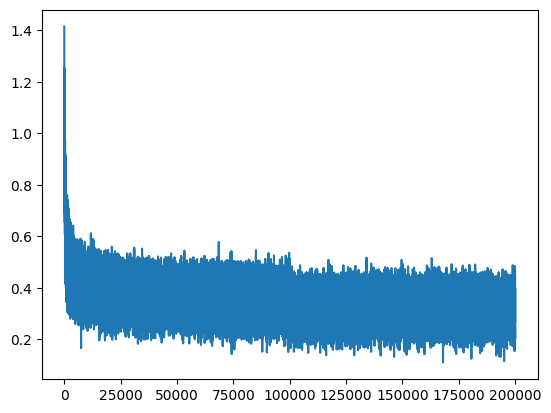

In [11]:
# plot loss over training
plt.plot(lossi)

In [12]:
# evaluate on train, val, or test set

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1201181411743164
val 2.1686477661132812


In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
nihayla.
ren.
ruckadraeg.
aderedieliigh.
poren.
eden.
esmanaraelyn.
malaia.
noshubergihiriel.
kendreelle.
joseromi.
brence.
ryyah.
faeha.
kayshusteyan.
hal.
salynn.


There are a few problems with our model. The first is the initialization. <br>
We should have a baseline estimate for how well our model will do at initialization (first iteration of forward and backward pass, or first loss function). Ours is ~26, which is way too high. <br>
A better baseline is to assume a uniform distribution for all possible outcomes. In this case, any character is equally likely to be the next character in the sequence.

In [14]:
# negative log likelihood of uniform prediction
-torch.tensor(1/27.0).log()

tensor(3.2958)

So we expect the initialization to be about 3.

In [16]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn(vocab_size,                        generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

print(f'{loss.item()=}')
print(logits[0])

C.shape=torch.Size([27, 10])
W1.shape=torch.Size([30, 200])
b1.shape=torch.Size([200])
W2.shape=torch.Size([200, 27])
b2.shape=torch.Size([27])
Parameter total: 11897
loss.item()=27.881731033325195
tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)


The extreme values in the logits are causing the loss to start extremely high. Let's alter the first-iteration logits to be much closer to zero. Since `logits = h @ W2 + b2`, we can zero out the `b2` bias for the first pass and shrink the effect of `W2` to bring our initial logit values closer to zero (in other words, make it more uniform)

In [18]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
# shrink W2 and zero out b2
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

print(f'{loss.item()=}')
print(logits[0])

C.shape=torch.Size([27, 10])
W1.shape=torch.Size([30, 200])
b1.shape=torch.Size([200])
W2.shape=torch.Size([200, 27])
b2.shape=torch.Size([27])
Parameter total: 11897
loss.item()=3.322058916091919
tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)


A better initial result. With a high initial loss, our model is starting much further away from the optimal loss value. Our model is more likely to achieve an optimal loss value if it starts closer to the finish line.

In [19]:
# retrain model
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
max_steps = 200_000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

C.shape=torch.Size([27, 10])
W1.shape=torch.Size([30, 200])
b1.shape=torch.Size([200])
W2.shape=torch.Size([200, 27])
b2.shape=torch.Size([27])
Parameter total: 11897
      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


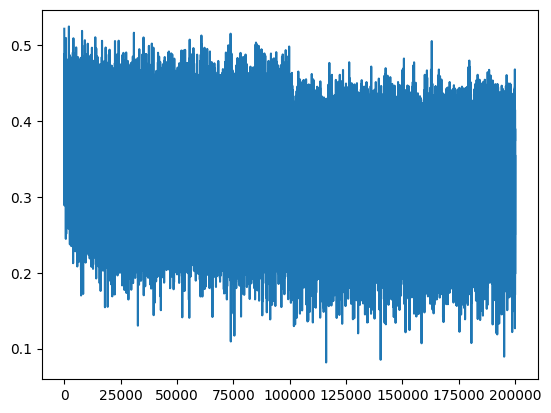

In [20]:
plt.plot(lossi);

In [21]:
split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310746669769287


A slightly better score for training and validation.

The second problem our initialization faces is the tanh function.

In [22]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

print(h)

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)


In [33]:
print(f'{h.shape=}')
total_cells = h.shape[0]*h.shape[1]
print(f'{total_cells=}')
ones = (h == 1.).sum(dim=0).sum() + (h == -1.).sum(dim=0).sum()
print(f'{ones.item()=}')
print('Ones Ratio:', (ones / total_cells).item())

h.shape=torch.Size([32, 200])
total_cells=6400
ones.item()=525
Ones Ratio: 0.08203125


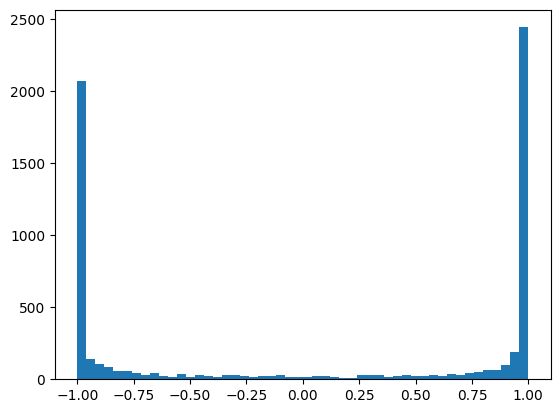

In [35]:
plt.hist(h.view(-1).tolist(), 50);

Almost 8% of the tanh values start at 1 or -1. The preactivations can also tell us a lot about why this "saturation" exists in the tanh.

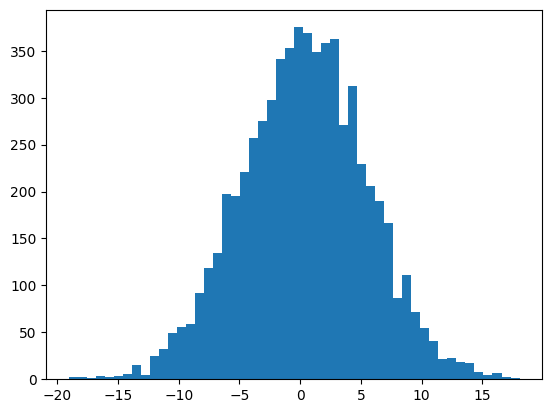

In [36]:
plt.hist(hpreact.view(-1).tolist(), 50);

There is a very wide range of values in the preactivation, which must be squashed into a tanh range. So, most of the values are ending up at the edges (i.e. -1 or 1).

We can visualize the pervasiveness of the problem by viewing h (the 200 hidden neurons for each of 32 examples).

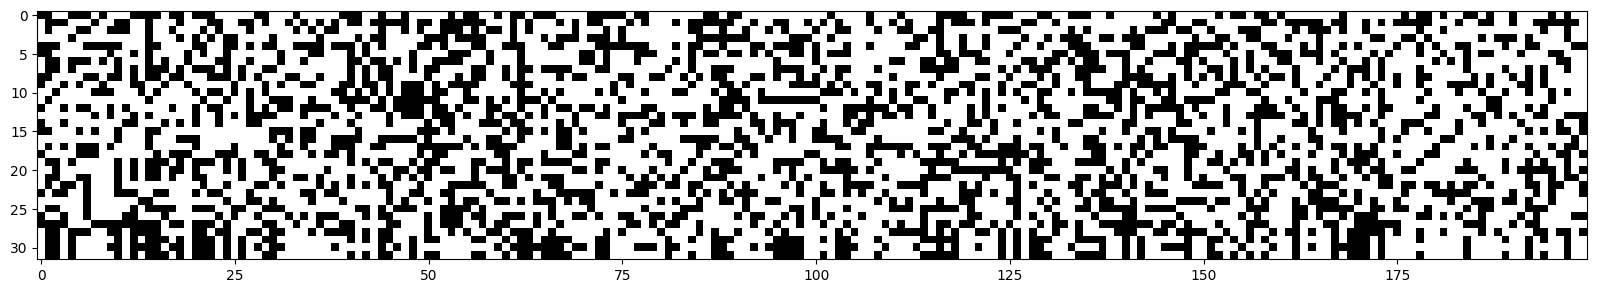

In [38]:
# extreme activations in white
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

All the white pixels have flat, or near-zero, gradients. <br>
Columns of all white, or mostly white, pixels are indications of "dead neurons".
So, these neurons are not being updated (or barely updated) on the backward pass. <br>
So, we're losing a lot of information just from bad neuron initialization! <br>

Note, it would be a lot worse if there were any truly "dead neurons".

The way to fix this is to, like with the second round of weights and biases, squash the first round.

In [60]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
# squash initial weights and biases
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g) * 0.2
b1 = torch.randn(n_hidden,                          generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)

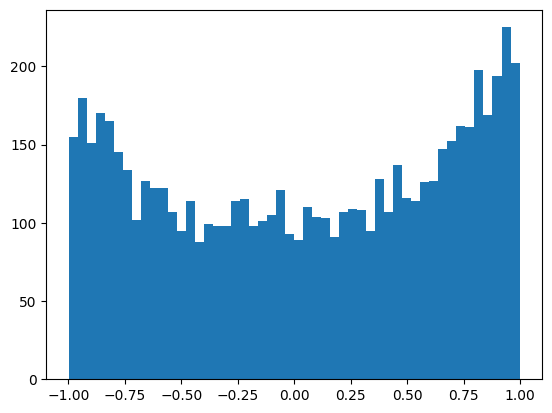

In [61]:
plt.hist(h.view(-1).tolist(), 50);

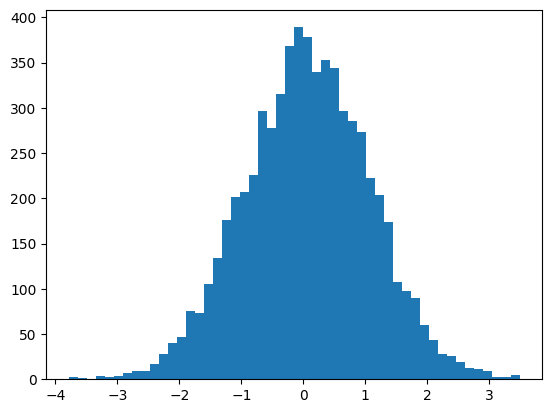

In [62]:
plt.hist(hpreact.view(-1).tolist(), 50);

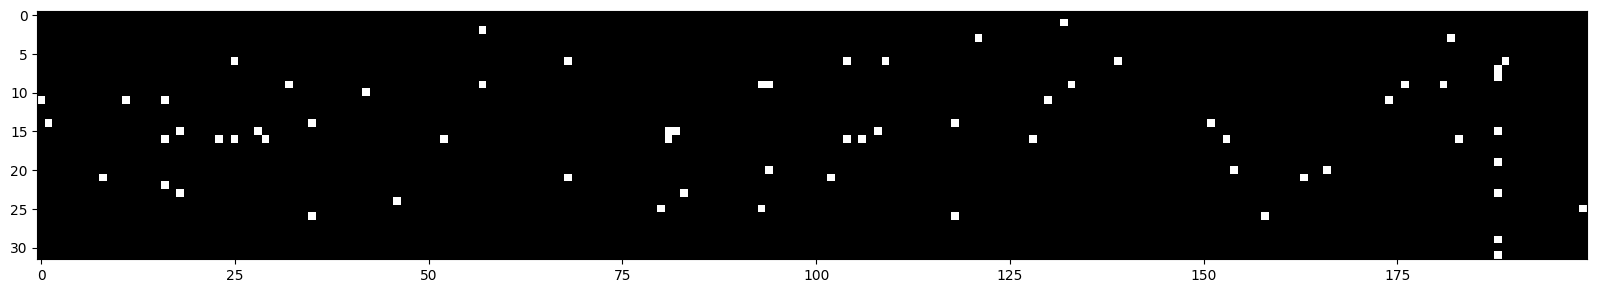

In [63]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

A much better result, across all accounts.

In [64]:
# retrain model
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g) * 0.2
b1 = torch.randn(n_hidden,                          generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
max_steps = 200_000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3143
  10000/ 200000: 2.1572
  20000/ 200000: 2.2496
  30000/ 200000: 2.4771
  40000/ 200000: 1.9847
  50000/ 200000: 2.3918
  60000/ 200000: 2.4417
  70000/ 200000: 2.0306
  80000/ 200000: 2.2679
  90000/ 200000: 2.0800
 100000/ 200000: 1.8231
 110000/ 200000: 2.0840
 120000/ 200000: 1.9513
 130000/ 200000: 2.3577
 140000/ 200000: 2.1744
 150000/ 200000: 2.0942
 160000/ 200000: 1.8275
 170000/ 200000: 1.7911
 180000/ 200000: 1.9139
 190000/ 200000: 1.8489


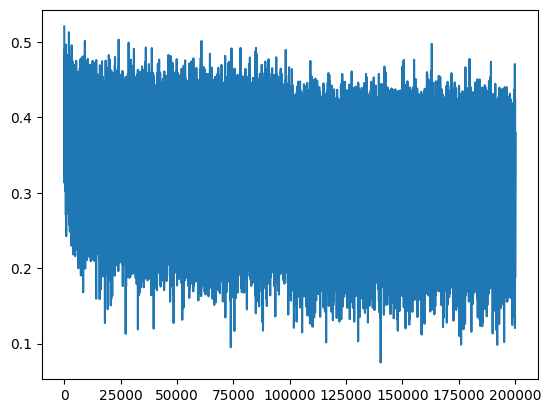

In [65]:
plt.plot(lossi)

In [66]:
split_loss('train')
split_loss('val')

train 2.0366368293762207
val 2.1003050804138184


The final problem with initialization is the lack of normalization after the matrix multiplication occurs within the layers. For example:

x.mean()=tensor(-0.0196), x.std()=tensor(0.9987)
y.mean()=tensor(0.0098), y.std()=tensor(3.1872)


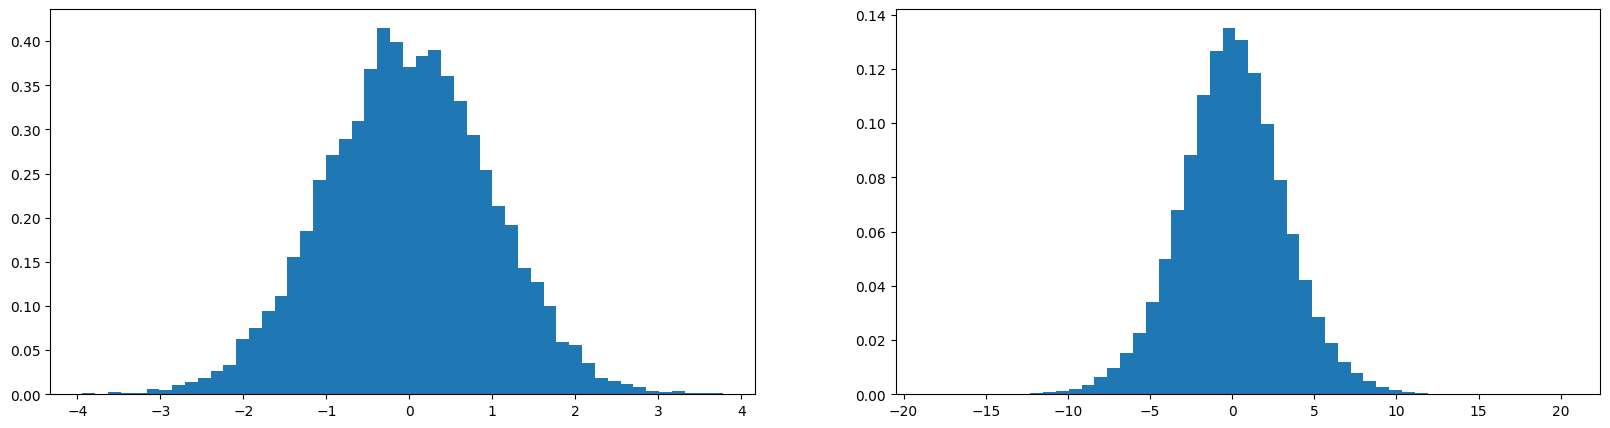

In [67]:
# example of output value explosion
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(f'{x.mean()=}, {x.std()=}')
print(f'{y.mean()=}, {y.std()=}')
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

After the matrix multiplication occurs, the distribution now has much wider tails (or sometimes smaller). This can easily cause explosions or deaths of gradients within the neural network, so it's important to normalize the outcomes. A semi-principled initialization is the "kaiming init". For tanh, this is $$ \frac{5}{3} * \frac{1}{\sqrt{\text{fan-in}}} $$ where fan-in is the number of input neurons.

In [68]:
# redefine normalization
def kaiming_tanh(fanin):
    return (5/3) * fanin**-0.5

      0/ 200000: 3.3180
  10000/ 200000: 2.2065
  20000/ 200000: 2.3094
  30000/ 200000: 2.5224
  40000/ 200000: 1.9679
  50000/ 200000: 2.3158
  60000/ 200000: 2.4154
  70000/ 200000: 2.1406
  80000/ 200000: 2.2962
  90000/ 200000: 2.2014
 100000/ 200000: 1.8528
 110000/ 200000: 2.1134
 120000/ 200000: 1.9186
 130000/ 200000: 2.3040
 140000/ 200000: 2.1492
 150000/ 200000: 2.1718
 160000/ 200000: 1.7871
 170000/ 200000: 1.7597
 180000/ 200000: 1.9579
 190000/ 200000: 1.8089
train 2.0380070209503174
split_loss("train")=None
val 2.106062650680542
split_loss("val")=None


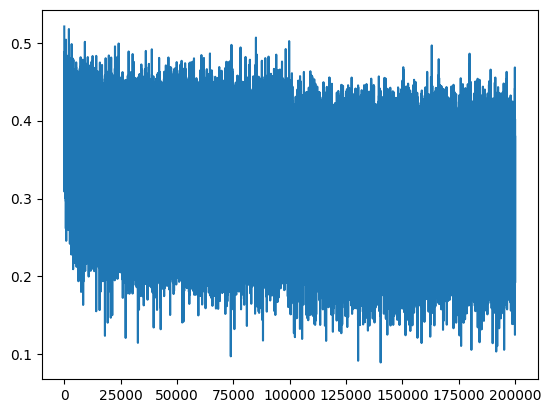

In [69]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
# initialize with kaiming init
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g) * kaiming_tanh(n_embed*block_size)
b1 = torch.randn(n_hidden,                          generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
max_steps = 200_000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

plt.plot(lossi);

split_loss("train")
split_loss("val")

As it turns out, this gaussian normalization is differentiable, and so we can do this with all of our pre-activations - using "batch activation".

However, we don't want to normalize after every iteration, only the first (initialization). Rather, we would like to maintain gaussian neuron distributions through the training, but we want to be able to stretch, squish, and shift these distributions as the training data changes the model.

To accomplish this, we need a gain and a bias, where the gain will cause the stretching or squishing, and the bias will handle the shift.

At initialization, these values will be 1 and 0, respectively, for the distributions to be gaussian at the start.

In [72]:
print('preactivation shape:', hpreact.shape)
print('preactivation mean shape:', hpreact.mean(0, keepdim=True).shape)
print('preactivation std shape:', hpreact.std(0, keepdim=True).shape)

preactivation shape: torch.Size([32, 200])
preactivation mean shape: torch.Size([1, 200])
preactivation std shape: torch.Size([1, 200])


In [73]:
def custom_batchnorm(preact_tensor, gain, bias):
    return (
        gain # stretch or squish
        * (preact_tensor - preact_tensor.mean(0, keepdim=True)) # deviation
        / preact_tensor.std(0, keepdim=True) # normalize
        + bias # shift
    )

In [81]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g) * kaiming_tanh(n_embed*block_size)
b1 = torch.randn(n_hidden,                          generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

# batch normalization gain and bias
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [82]:
# evaluate on train, val, or test set

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = custom_batchnorm(hpreact, bngain, bnbias)
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

      0/ 200000: 2.5138
  10000/ 200000: 1.9840
  20000/ 200000: 1.9788
  30000/ 200000: 2.2299
  40000/ 200000: 2.4285
  50000/ 200000: 1.9317
  60000/ 200000: 2.4374
  70000/ 200000: 2.3442
  80000/ 200000: 1.8442
  90000/ 200000: 2.0929
 100000/ 200000: 2.1363
 110000/ 200000: 2.6384
 120000/ 200000: 1.9187
 130000/ 200000: 1.4003
 140000/ 200000: 2.5213
 150000/ 200000: 2.1159
 160000/ 200000: 1.5691
 170000/ 200000: 2.3372
 180000/ 200000: 2.7313
 190000/ 200000: 2.3549
train 2.057408571243286
val 2.1011834144592285


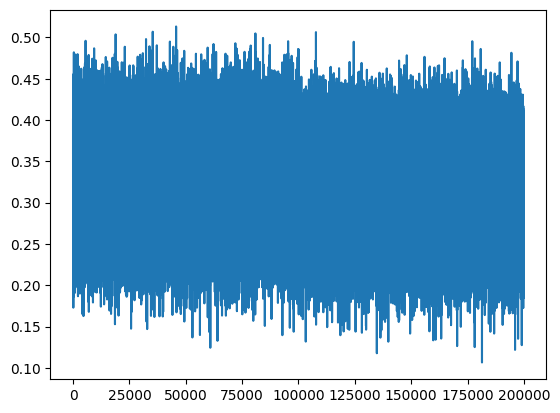

In [84]:
max_steps = 200_000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # batch normalization
  hpreact = custom_batchnorm(hpreact, bngain, bnbias)
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

plt.plot(lossi);

split_loss("train")
split_loss("val")

Batch normalization, for the wondrous stability that it introduces into the neurons of a network, come with a cost: the examples within a batch are no longer individual; they are mathematically coupled throughout the network (they are modified by the batch mean and standard deviation).

Despite this downside, it causes a positive: the hidden layer and logits begin to "jitter", which acts like regularization in the form of entropy, thereby preventing overfitting.

Network builders on the bleeding edge of tech are trying to get away from batch normalization because of the example coupling, but are finding the transition difficult because batch normalization works so well as a regularizer.

The other downside of batch normalization is that we are unable to generate predictions based on a single input. We cannot generate samples, because the batch normalization always expects batches to train.

To fix this, we will calibrate the batch norm at the end of the training, then use the final mean and standard deviation for the gain and bias in the batch normalization step for an example input.

In [85]:
# calibrate batch norm

with torch.no_grad():
    # pass in training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure mean and std over entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [86]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [87]:
split_loss('train')
split_loss('val')

train 2.057408571243286
val 2.1012351512908936


However, calculating the mean and standard deviation over the entire testing set at the end of training is slow. Rather, we can keep a running mean and std throughout the training, and then use those for the final mean and std.

In [105]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g) * kaiming_tanh(n_embed*block_size)
b1 = torch.randn(n_hidden,                          generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# running mean and std
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [106]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347
train 2.06659197807312
val 2.1050572395324707


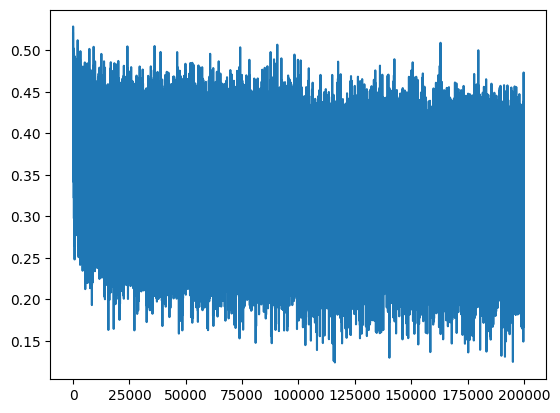

In [107]:
max_steps = 200_000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # calculate batch mean and std
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  # new custom batchnorm function
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

plt.plot(lossi);

split_loss("train")
split_loss("val")

Another impact of batch normalization is the neutering of any biases (like `b1` and `b2`) added in the linear layers. Because the example mean is subtracted from any example (thereby only getting the deviation), any bias is effectively removed (since it is added to every example).

In [108]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),              generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),    generator=g) * kaiming_tanh(n_embed*block_size)
# b1 = torch.randn(n_hidden,                          generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
# b2 = torch.randn(vocab_size,                        generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# running mean and std
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# removed biases from parameters
parameters = [C, W1, W2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [109]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 #+ b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

      0/ 200000: 3.3195
  10000/ 200000: 2.4093
  20000/ 200000: 2.3101
  30000/ 200000: 1.9834
  40000/ 200000: 2.0810
  50000/ 200000: 1.8933
  60000/ 200000: 2.0694
  70000/ 200000: 2.3146
  80000/ 200000: 1.7209
  90000/ 200000: 2.0356
 100000/ 200000: 2.0370
 110000/ 200000: 2.3104
 120000/ 200000: 2.2858
 130000/ 200000: 2.3039
 140000/ 200000: 1.9800
 150000/ 200000: 2.0748
 160000/ 200000: 2.1306
 170000/ 200000: 2.2551
 180000/ 200000: 1.8987
 190000/ 200000: 2.1405
train 2.0674996376037598
val 2.106266498565674


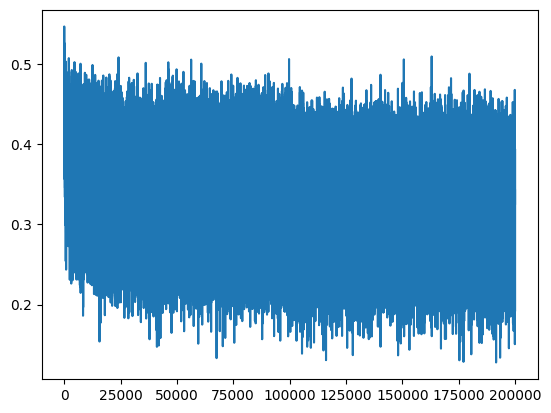

In [110]:
max_steps = 200_000
batch_size = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  h = torch.tanh(hpreact)
  logits = h @ W2 #+ b2
  loss = F.cross_entropy(logits, Yb)
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

plt.plot(lossi);

split_loss("train")
split_loss("val")